In [4]:
% reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Import packages / libraries.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from scipy.spatial import distance

## Import POI locations dataset.

### It consists of 4 columns and "POI1" and "POI1" are identical.

In [6]:
data_POI = pd.read_csv('C:/Users/sbadretale/Desktop/ws-data-spark-master/ws-data-spark-master/data/POIList.csv')

print('data shape:' ,data_POI.shape)
data_POI
# data_POI.columns

data shape: (4, 3)


,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


### Renaming the column "Latitude"  to remove the space.

In [7]:
print('data columns: ', data_POI.columns)
data_POI = data_POI.rename(index=str, columns={" Latitude": "Latitude"})

data columns:  Index(['POIID', ' Latitude', 'Longitude'], dtype='object')


## Import the request dataset

### It consists of 22025 requests.

In [8]:
data_sample = pd.read_csv('C:/Users/sbadretale/Desktop/ws-data-spark-master/ws-data-spark-master/data/DataSample.csv')

print('Total Number of requests: ' , data_sample.shape[0])

data_sample.head(5)

Total Number of requests:  22025


,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730


### Checking the type of each column in the request dataset.

#### "Latitude" and "Longitude" are float64. "ID" is int64 and the rest are non-numeric columns.

In [9]:
data_sample.dtypes

_ID            int64
 TimeSt       object
Country       object
Province      object
City          object
Latitude     float64
Longitude    float64
dtype: object

### Checking to see if Latitude is in the range of (-90, 90) and Longitude is in the range of (-180, 180) to detect outliers.   --> Answer is Yes

#### Latitude is in the range of (6.92742 , 62.8273) and Longitude is in (-136.53957 , 125.7022). 

In [10]:
data_sample.describe()

,_ID,Latitude,Longitude
count,2.202500e+04,22025.000000,22025.000000
mean,5.067292e+06,47.983484,-94.967281
std,3.175577e+05,4.165093,19.092001
min,4.516516e+06,6.927420,-136.539570
25%,4.792159e+06,43.747600,-113.814000
50%,5.067906e+06,47.798700,-83.018000
75%,5.342586e+06,51.128560,-79.399100
max,5.615006e+06,62.827300,125.702200


### Renaming the column "TimeSt" to remove the space

In [11]:
data_sample = data_sample.rename(index=str, columns={" TimeSt": "TimeSt"})
data_sample.head(5)

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730


##  0.  Cleanup : FInding duplicates in geoinfo and timest

### I added the last column 'Location_index' to locate the duplicated column in the request dataset ( e.g. ID12 and ID7 are duplicates.) 

### Number of duplicate requests: 2026

In [12]:
## Checking for duplicates in time and location columns 
data_sample_tmp = data_sample [:]
data_sample_tmp['Location_index'] = data_sample_tmp.groupby(['TimeSt','Latitude','Longitude']).transform('idxmin') 
data_sample_duplicate = data_sample_tmp[data_sample_tmp.duplicated(subset=['TimeSt' , 'Latitude' , 'Longitude'], keep='first')]
print('Number of duplicates:' ,data_sample_duplicate.shape[0])
data_sample_duplicate.head(5)

Number of duplicates: 2026


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,_ID,TimeSt,Country,Province,City,Latitude,Longitude,Location_index
12,4517047,2017-06-21 12:00:00.950,CA,ON,London,43.00910,-81.17650,7
19,4517347,2017-06-21 03:00:00.287,CA,ON,Windsor,42.29570,-82.95990,17
37,4518179,2017-06-21 08:00:00.663,CA,ON,Kitchener,43.46760,-80.48470,32
56,4519066,2017-06-21 07:00:00.747,CA,ON,Tillsonburg,42.86185,-80.72991,54
77,4520202,2017-06-21 17:00:02.433,CA,ON,Windsor,42.26540,-83.02610,73


### Creating a dataset "data_no_duplicate" for non-duplciate requests.

### Number of non-duplicate requests is 19999.

In [27]:
duplicate_bool = data_sample.duplicated(subset=['TimeSt','Latitude','Longitude'], keep='first')
data_no_duplicate = data_sample.loc[duplicate_bool == False]
print('Number of non-duplicates:' , data_no_duplicate.shape[0]) 

Number of non-duplicates: 19999


#### ## Checking for Null values in request datasets --> No Null values.

In [15]:
data_sample.isnull().values.any()

False

# 1. Label: assign each request to one of the POI locations that has minimum distance to the request location.

### I used the Euclidean function in scipy to find the distance between requests and POI locations. 

In [16]:
Label = []
dist = []
for i in range(data_no_duplicate.shape[0]):
  for j in range(4):
    points_smaple = [data_no_duplicate.Latitude[i],data_no_duplicate.Longitude[i]]  # find the Latitude and Longitude in request
    points_POI = [data_POI.Latitude[j],data_POI.Longitude[j]]   # find the Latitude and Longitude in POI locations for 4 coulmns
    dist.append(distance.euclidean(points_smaple , points_POI))  # Calculate the Eucledean distance between two points 
  Label.append(dist.index(min(dist)))  # Find the index of the Min distance
  dist = []
  
data_no_duplicate['Label'] = Label

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


### Counting the label distribution

### Since POI1 and POI2 are identical, POI2 location is empty and all the requests for these two locations are in POI1. 

#### Based on the result, %48.5 of requests belong to POI1, %49 of requests are in POI3, and %2.5 are in POI4. 

In [17]:
# Counting the label distribution

POI_Location_1 = len(data_no_duplicate[data_no_duplicate['Label']==0])
POI_Location_2 = len(data_no_duplicate[data_no_duplicate['Label']==1])
POI_Location_3 = len(data_no_duplicate[data_no_duplicate['Label']==2])
POI_Location_4 = len(data_no_duplicate[data_no_duplicate['Label']==3])
total = POI_Location_1 + POI_Location_2 + POI_Location_3 + POI_Location_4

Percentage_of_POI_Location_1 = POI_Location_1/total
print('% of POI location 1 requests       :', Percentage_of_POI_Location_1*100)
print('Number of POI location 1  requests    :', POI_Location_1)

Percentage_of_POI_Location_2 = POI_Location_2/total
print('% of POI location 2 requests         :', Percentage_of_POI_Location_2*100)
print('Number of POI location 2 requests   :', POI_Location_2)

Percentage_of_POI_Location_3 = POI_Location_3/total
print('% of POI location 3 requests         :', Percentage_of_POI_Location_3*100)
print('Number of POI location 3 requests   :', POI_Location_3)

Percentage_of_POI_Location_4 = POI_Location_4/total
print('% of POI location 4 requests        :', Percentage_of_POI_Location_4*100)
print('Number of POI location 4 requests   :', POI_Location_4)

% of POI location 1 requests       : 48.49242462123106
Number of POI location 1  requests    : 9698
% of POI location 2 requests         : 0.0
Number of POI location 2 requests   : 0
% of POI location 3 requests         : 49.08745437271864
Number of POI location 3 requests   : 9817
% of POI location 4 requests        : 2.4201210060503024
Number of POI location 4 requests   : 484


### Histogram of the POI locations

#### Class0 :  POI1  ,   Class1 :  POI3  ,   Class2 :  POI4

Text(0,0.5,'Frequency')

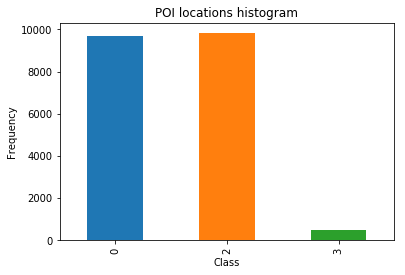

In [18]:
count_classes = pd.value_counts(data_no_duplicate['Label'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("POI locations histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

### Scatterplot for each POI locaiton

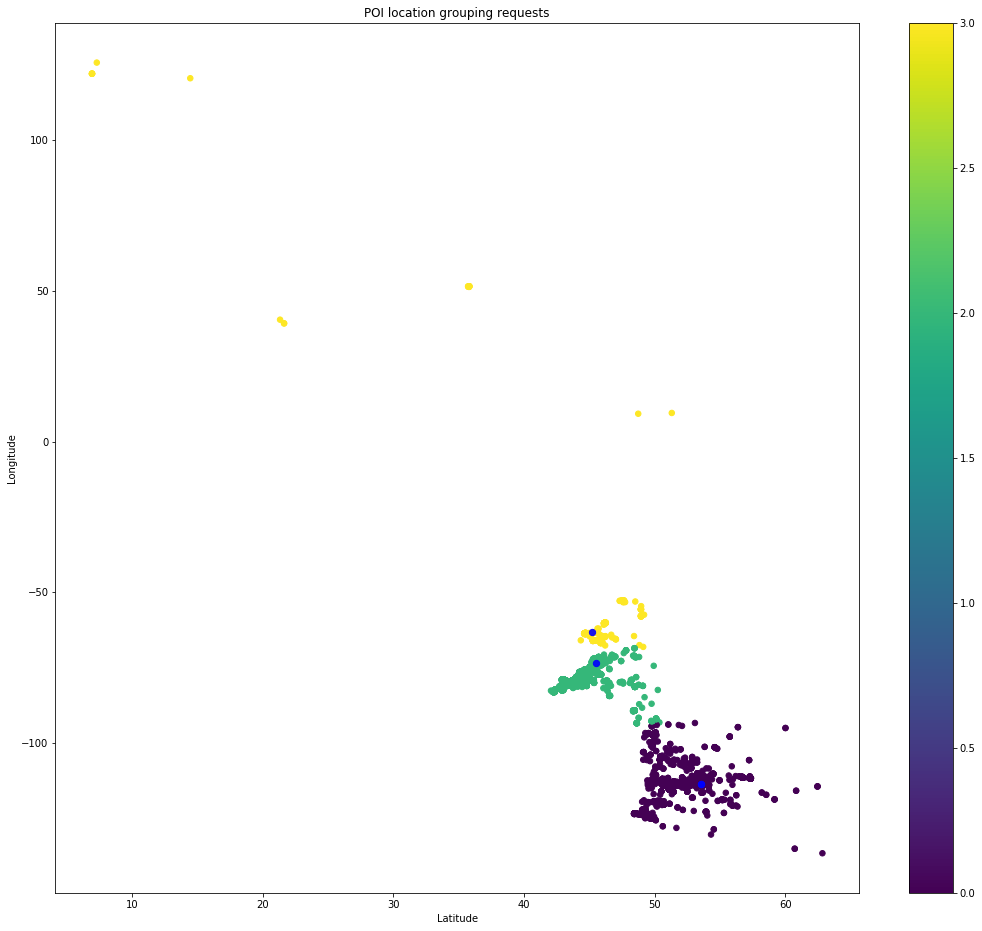

In [19]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
scatter = ax.scatter(data_no_duplicate['Latitude'],data_no_duplicate['Longitude'],
                     c=data_no_duplicate['Label'],cmap='viridis', s=30)

plt.scatter(data_POI['Latitude'], data_POI['Longitude'], c='b', s=40, alpha=0.9);

ax.set_title('POI location grouping requests')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.colorbar(scatter)

# 2. Analysis : With respect to each POI location, calculate the average and standard deviation of distance between the POI location to each of its assigned requests.

### Average Value:

In [20]:
tmp_data = data_no_duplicate.groupby(['Label']).mean()

POI_Location_0_mean = [tmp_data.iloc[0,1] - data_POI.iloc[0,1], tmp_data.iloc[0,2] - data_POI.iloc[0,2]]

print('Mean value of POI_Location_1:     ', POI_Location_0_mean)

POI_Location_2_mean = [tmp_data.iloc[1,1] - data_POI.iloc[2,1], tmp_data.iloc[1,2] - data_POI.iloc[2,2]]

print('Mean value of POI_Location_3:     ', POI_Location_2_mean)

POI_Location_3_mean = [tmp_data.iloc[2,1] - data_POI.iloc[3,1], tmp_data.iloc[2,2] - data_POI.iloc[3,2]]

print('Mean value of POI_Location_4:     ', POI_Location_3_mean)

Mean value of POI_Location_1:      [-1.6269621567335122, 0.13417244297784237]
Mean value of POI_Location_3:      [-1.279085826932672, -5.196635388814244]
Mean value of POI_Location_4:      [-0.19461688016530587, 6.2843858388429865]


### Standard deviation:

In [21]:
data_no_duplicate.groupby(['Label']).std()

,_ID,Latitude,Longitude
Label,,,
0,311055.776141,1.647030,4.552080
2,323468.669155,1.192507,2.962779
3,322253.833108,5.200071,28.868550


# 2. Analysis : Draw circles that are centered at each of the POIs, each includes all requests assigned to the POI location. Find out the radius and density (i.e. request count/circle area) for each POI location.

In [22]:
## Separate the dataset (requests) by the value of the label (POI locations)

grouped_df = data_no_duplicate.groupby(['Label'])

POI_Location_0_data = grouped_df.get_group(0)
POI_Location_2_data = grouped_df.get_group(2)
POI_Location_3_data = grouped_df.get_group(3)

In [23]:
radius0 = []
for i in range(POI_Location_0_data.shape[0]):
  points_smaple = [POI_Location_0_data.Latitude[i],POI_Location_0_data.Longitude[i]]  # find the Latitude and Longitude in sample data
  points_POI = [data_POI.Latitude[0],data_POI.Longitude[0]]   # find the Latitude and Longitude in POI data for 4 coulmns
  radius0.append(distance.euclidean(points_smaple , points_POI))  # Calculate the Eucledean distance between two location points 
  
print('POI Location 1 radius is:  %f and density is: %f  ' % ( max(radius0), POI_Location_1 / (2 * pi * max(radius0)* max(radius0))))


POI Location 1 radius is:  24.851937 and density is: 2.499090  


In [24]:
radius1 = []
for i in range(POI_Location_2_data.shape[0]):
  points_smaple = [POI_Location_2_data.Latitude[i],POI_Location_2_data.Longitude[i]]  # find the Latitude and Longitude in sample data
  points_POI = [data_POI.Latitude[2],data_POI.Longitude[2]]   # find the Latitude and Longitude in POI data for 4 coulmns
  radius1.append(distance.euclidean(points_smaple , points_POI))  # Calculate the Eucledean distance between two location points 
  
print('POI Location 3 radius is:  %f and density is: %f  ' % ( max(radius1), POI_Location_3 / (2 * pi * max(radius1)* max(radius1))))

POI Location 3 radius is:  20.155378 and density is: 3.846069  


In [25]:
radius2 = []
for i in range(POI_Location_3_data.shape[0]):
  points_smaple = [POI_Location_3_data.Latitude[i],POI_Location_3_data.Longitude[i]]  # find the Latitude and Longitude in sample data
  points_POI = [data_POI.Latitude[3],data_POI.Longitude[3]]   # find the Latitude and Longitude in POI data for 4 coulmns
  radius2.append(distance.euclidean(points_smaple , points_POI))  # Calculate the Eucledean distance between two location points 
  
print('POI Location 4 radius is:  %f and density is: %f  ' % ( max(radius2), POI_Location_4 / (2 * pi * max(radius2)* max(radius2))))

POI Location 4 radius is:  192.704991 and density is: 0.002074  


### Since in POI 4, radius = 192 so the corresponding circle is quite large. ( I will deal with this as outliers in bonus part)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


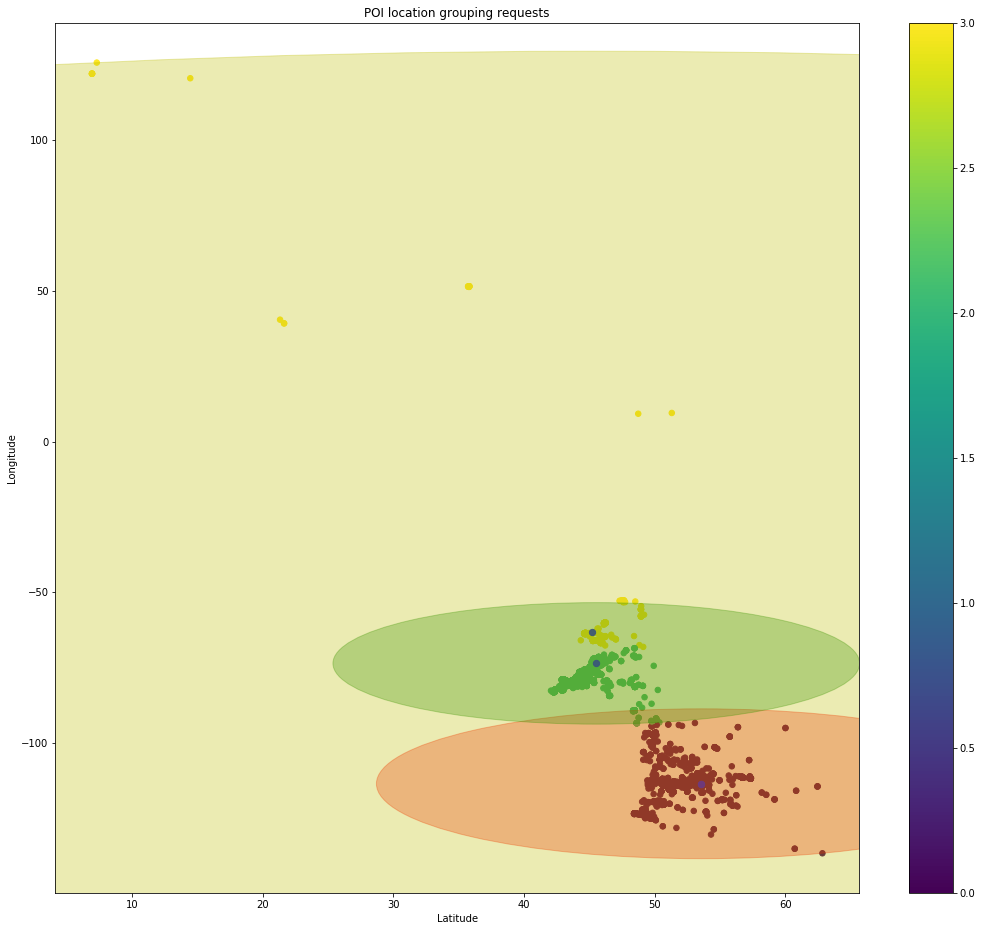

In [26]:
circle1 = plt.Circle((data_POI.Latitude[0],data_POI.Longitude[0]), max(radius0),  color='r', alpha=0.3, edgecolor='none')
circle2 = plt.Circle((data_POI.Latitude[2],data_POI.Longitude[2]), max(radius1),  color='g', alpha=0.3, edgecolor='none')
circle3 = plt.Circle((data_POI.Latitude[3],data_POI.Longitude[3]), max(radius2),  color='y', alpha=0.3, edgecolor='none')

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
scatter = ax.scatter(data_no_duplicate['Latitude'],data_no_duplicate['Longitude'],
                     c=data_no_duplicate['Label'],cmap='viridis', s=30)

plt.scatter(data_POI['Latitude'], data_POI['Longitude'], c='b', s=40, alpha=0.9);
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)

ax.set_title('POI location grouping requests')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.colorbar(scatter)

# 3. Model (Bonus)

## Since POI location4 has a radius of 192 and only consists of %2.5 of total requests, we can consider some points as outliers. We can detect the outliers with interquantile values: 

### If  IQR=Q3-Q1,  then values in the range of ( -inf, Q1-1.5 × IQR ) and ( Q3+1.5 × IQR, inf) can be considered as outliers.  

In [28]:
## apply the interquartile on the Request dataset, and then find the label (POI Locations) for each request
data_sample.shape
cols = ['Latitude','Longitude']

### 14 requests in Latitude are considered as outliers

In [38]:
# Computing IQR for latitute 
data_sample2  = data_no_duplicate[cols]
Q1 = data_sample2['Latitude'].quantile(0.25)
Q3 = data_sample2['Latitude'].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
data_sample2 = data_sample2.query('(@Q1 - 1.5 * @IQR) <= Latitude <= (@Q3 + 1.5 * @IQR)')
print('Number of outliers found in column Latitude: ' , data_no_duplicate.shape[0] - data_sample2.shape[0])

Number of outliers found in column Latitude:  14


### 26 requests in Longitude are considered as outliers

In [39]:
data_sample3  = data_sample2[cols]
Q1 = data_sample3['Longitude'].quantile(0.25)
Q3 = data_sample3['Longitude'].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
data_sample3 = data_sample3.query('(@Q1 - 1.5 * @IQR) <= Longitude <= (@Q3 + 1.5 * @IQR)')
print('Number of outliers found in column Longitude: ' , data_no_duplicate.shape[0] - data_sample3.shape[0])

Number of outliers found in column Longitude:  26


### assign each request to one of the POI locations that has minimum distance to the request location.

In [40]:
Label = []
dist = []
for i in range(data_sample3.shape[0]):
  for j in range(4):
    points_smaple = [data_sample3.Latitude[i],data_sample3.Longitude[i]]  # find the Latitude and Longitude in sample data
    points_POI = [data_POI.Latitude[j],data_POI.Longitude[j]]   # find the Latitude and Longitude in POI data for 4 coulmns
    dist.append(distance.euclidean(points_smaple , points_POI))  # Calculate the Eucledean distance between two location points 
  Label.append(dist.index(min(dist)))  # Find the index of the Min distance
  dist = []
  
data_sample3['Label'] = Label

### I used boxplot to visualize the detected outliers in Interquantile method.

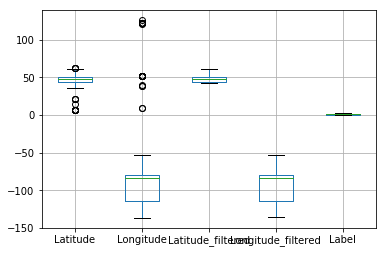

In [41]:
data_sample_tmp  = data_sample[cols]
# Ploting the result to check the difference
data_sample_tmp.join(data_sample3, rsuffix='_filtered').boxplot()

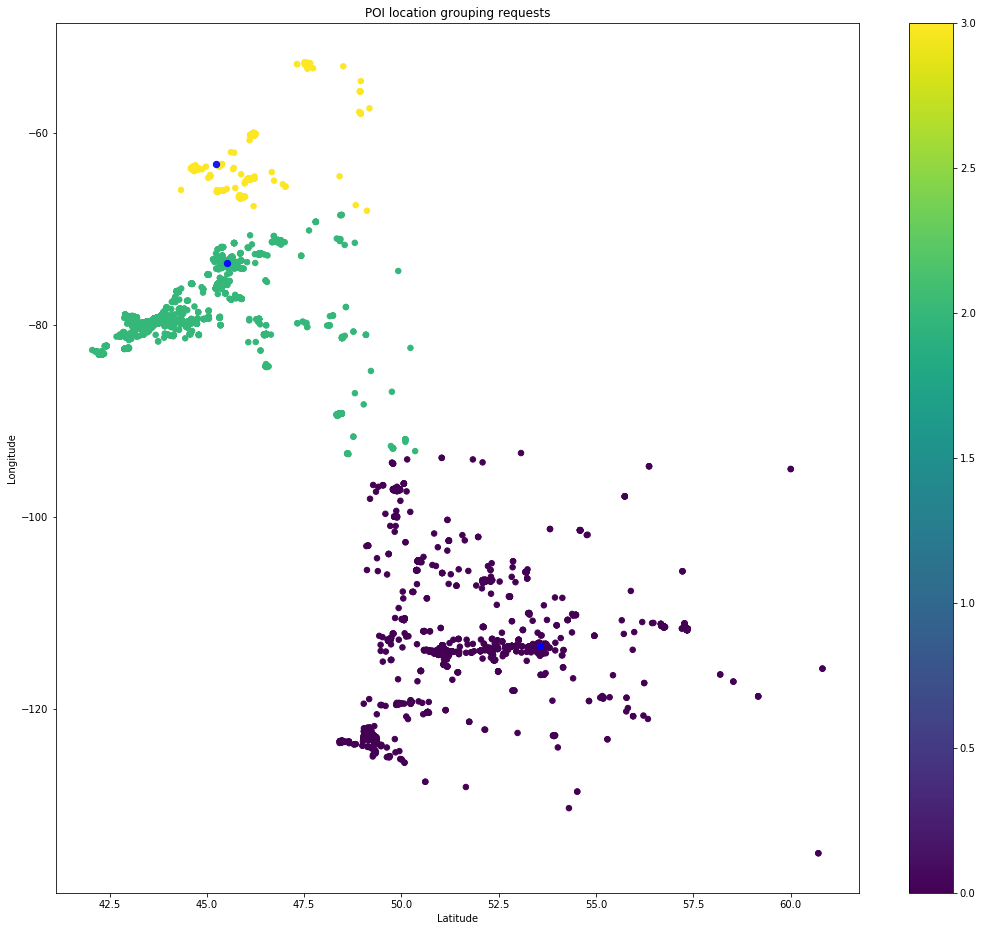

In [42]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
scatter = ax.scatter(data_sample3['Latitude'],data_sample3['Longitude'],
                     c=data_sample3['Label'],cmap='viridis', s=30)

plt.scatter(data_POI['Latitude'], data_POI['Longitude'], c='b', s=40, alpha=0.9);
ax.set_title('POI location grouping requests')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.colorbar(scatter)

In [43]:
POI_Location_sample_1 = len(data_sample3[data_sample3['Label']==0])
POI_Location_sample_2 = len(data_sample3[data_sample3['Label']==1])
POI_Location_sample_3 = len(data_sample3[data_sample3['Label']==2])
POI_Location_sample_4 = len(data_sample3[data_sample3['Label']==3])

In [44]:
## Separate the dataset (requests) by the value of the label (POI locations)

grouped_df = data_sample3.groupby(['Label'])

POI_Location_0_data_sample3 = grouped_df.get_group(0)
POI_Location_2_data_sample3 = grouped_df.get_group(2)
POI_Location_3_data_sample3 = grouped_df.get_group(3)

In [45]:
radius0 = []
for i in range(POI_Location_0_data_sample3.shape[0]):
  points_smaple = [POI_Location_0_data_sample3.Latitude[i],POI_Location_0_data_sample3.Longitude[i]]  # find the Latitude and Longitude in sample data
  points_POI = [data_POI.Latitude[0],data_POI.Longitude[0]]   # find the Latitude and Longitude in POI data for 4 coulmns
  radius0.append(distance.euclidean(points_smaple , points_POI))  # Calculate the Eucledean distance between two location points 
  
print('POI Location 1 radius is:  %f and density is: %f  ' % ( max(radius0), POI_Location_sample_1 / (2 * pi * max(radius0)* max(radius0))))


POI Location 1 radius is:  22.704383 and density is: 2.992980  


In [46]:
radius1 = []
for i in range(POI_Location_2_data_sample3.shape[0]):
  points_smaple = [POI_Location_2_data_sample3.Latitude[i],POI_Location_2_data_sample3.Longitude[i]]  # find the Latitude and Longitude in sample data
  points_POI = [data_POI.Latitude[2],data_POI.Longitude[2]]   # find the Latitude and Longitude in POI data for 4 coulmns
  radius1.append(distance.euclidean(points_smaple , points_POI))  # Calculate the Eucledean distance between two location points 
  
print('POI Location 3 radius is:  %f and density is: %f  ' % ( max(radius1), POI_Location_sample_3 / (2 * pi * max(radius1)* max(radius1))))

POI Location 3 radius is:  20.155378 and density is: 3.846069  


In [47]:
radius2 = []
for i in range(POI_Location_3_data_sample3.shape[0]):
  points_smaple = [POI_Location_3_data_sample3.Latitude[i],POI_Location_3_data_sample3.Longitude[i]]  # find the Latitude and Longitude in sample data
  points_POI = [data_POI.Latitude[3],data_POI.Longitude[3]]   # find the Latitude and Longitude in POI data for 4 coulmns
  radius2.append(distance.euclidean(points_smaple , points_POI))  # Calculate the Eucledean distance between two location points 
  
print('POI Location 4 radius is:  %f and density is: %f  ' % ( max(radius2), POI_Location_sample_4 / (2 * pi * max(radius2)* max(radius2))))

POI Location 4 radius is:  10.821120 and density is: 0.627939  


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


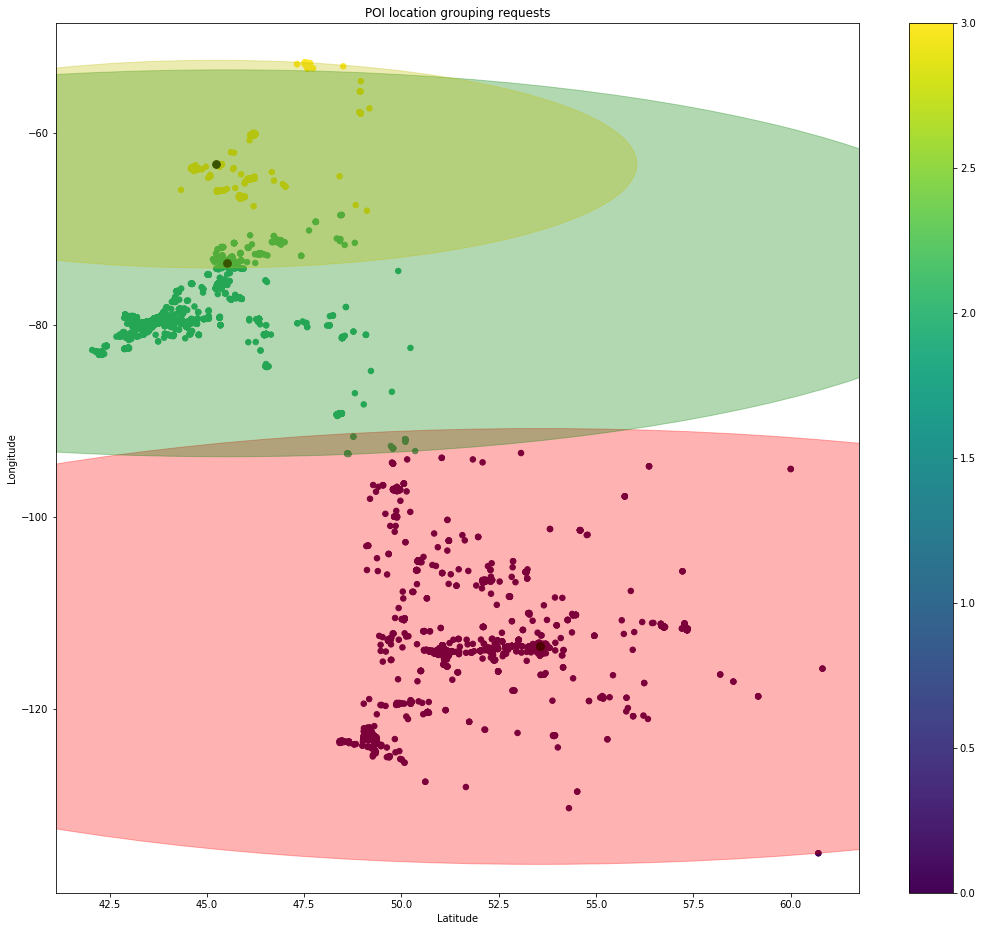

In [48]:
circle1 = plt.Circle((data_POI.Latitude[0],data_POI.Longitude[0]), max(radius0),  color='r', alpha=0.3, edgecolor='none')
circle2 = plt.Circle((data_POI.Latitude[2],data_POI.Longitude[2]), max(radius1),  color='g', alpha=0.3, edgecolor='none')
circle3 = plt.Circle((data_POI.Latitude[3],data_POI.Longitude[3]), max(radius2) , color='y', alpha=0.3, edgecolor='none')

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
scatter = ax.scatter(data_sample3['Latitude'],data_sample3['Longitude'],
                     c=data_sample3['Label'],cmap='viridis', s=30)

plt.scatter(data_POI['Latitude'], data_POI['Longitude'], c='black', s=60, alpha=1);
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.set_title('POI location grouping requests')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.colorbar(scatter)

In [ ]:
# I mapped the Latitude and Longitude using basemap, it wasn't useful since I noticed the data was genereted and it wasn't real.
# This part also takes time to run.

'''
from mpl_toolkits.basemap import Basemap
import matplotlib.cm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(20,20))
m = Basemap(llcrnrlon=data_sample.Longitude.min(),llcrnrlat=data_sample.Latitude.min(),
            urcrnrlon=data_sample.Longitude.max(),urcrnrlat=data_sample.Latitude.max(),
            resolution='i', # Set using letters, e.g. c is a crude drawing, f is a full detailed drawing
            projection='mill', # The projection style is what gives us a 2D view of the world for this
           ) 

# m.drawmapboundary(fill_color='#46bcec') # Make your map into any style you like
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec') # Make your map into any style you like
# m.fillcontinents() # Make your map into any style you like
m.drawcoastlines()
# m.drawrivers() # Default colour is black but it can be customised
m.drawcountries()
m.drawstates()
# m.etopo()
# m.bluemarble()

df = data_sample[:]
df['lat_lon'] = list(zip(data_sample.Latitude, data_sample.Longitude)) # Creating tuples

for i in df['lat_lon']:
    x,y = i
    m.plot(x, y, marker = 'o', c='r', markersize=1, alpha=0.8, latlon=False)

plt.show()
'''